# Using the Learning Rate Finder (Beginner)

> A guide for showing how to use the learning rate finder to select an ideal learning rate

- toc: true 
- badges: true
- comments: true
- author: Isaac Flath
- categories: [Neural Networks]

# The importance of a good Learning Rate

Before we get started, there's a few questions we need to understand.

#### Why bother selecting a learning rate? Why not use the defaults?

Quite simply, a bad learning rate can mean bad performance.  There are 2 ways this can happen.
1. **Learning too slowly**:  If the learning rate is too small it will take a really long time to train your model.  This can mean that to get a model of the same accuracy, you either would need to spend more time or more money.  Said another way, it will either take longer to train the model using the same hardware or you will need more expensive hardware (or some combination of the two).

1. Learning too quickly: If the learning rate is too large, the steps it takes will be so big it overshoots what is an optimal model.  Quite simply your accuracy will just bounce all over the place rather than steadily improving.

So we need a learning rate that is not too big, but not too small.  How can we thread the needle?

#### Isn't there some automated way to select a learning rate?

The short answer is no, there isn't.  There are some guidelines available that will be covered, but ultimately there is no sure-fire automated way to automated selectig a learning rate.  The best method is to to use the learning rate finder.

# The Problem

We will be identifying cats vs dogs.

>Note:  All details other than selecting a learning rate will be glossed over.  Please see https://docs.fast.ai/tutorial.vision for more detail on the actual modeling.

To get our model started, we will import the library.

In [1]:
from fastai.vision.all import *

Then download the data

In [2]:
path = untar_data(URLs.PETS)

Now, let's organize the data in a dataloader.  

In [5]:
files = get_image_files(path/"images")
def label_func(f): return f[0].isupper()
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

Now we can look at the pictures we are looking to classify.  We are predicting whether these images are a cat or not.

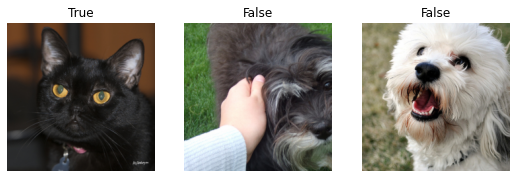

In [6]:
dls.show_batch(max_n=3)

Now, we can create a learner to do the classification.

In [7]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

# Learning Rate Finder

Finally we can get to the main topic of this tutorial.  I have modified the learning rate finder from fastai to add dots at the reccomended locations.  We can see a couple of red dots as fast reference points, but it is still on us to pick the value.  It's a bit of an art.

Here's the new code for the lr_find and plot_lr_find functions, which have been added to Walk With Fastai repo as well.

In [8]:
@patch
def plot_lr_find(self:Recorder, suggestions= False,skip_end=5, lr_min=None, lr_steep=None):
    "Plot the result of an LR Finder test (won't work if you didn't do `learn.lr_find()` before)"
    lrs    = self.lrs    if skip_end==0 else self.lrs   [:-skip_end]
    losses = self.losses if skip_end==0 else self.losses[:-skip_end]
    
    if suggestions:
        lr_min_index = min(range(len(lrs)), key=lambda i: abs(lrs[i]-lr_min))
        lr_steep_index = min(range(len(lrs)), key=lambda i: abs(lrs[i]-lr_steep))
    
    fig, ax = plt.subplots(1,1)
    ax.plot(lrs, losses)
    if suggestions:
        ax.plot(lr_min,L(losses)[lr_min_index],'ro')
        ax.plot(lr_steep,L(losses)[lr_steep_index],'ro')
    ax.set_ylabel("Loss")
    ax.set_xlabel("Learning Rate")
    ax.set_xscale('log')

@patch
def lr_find(self:Learner, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, show_plot=True, suggestions=True):
    "Launch a mock training to find a good learning rate, return lr_min, lr_steep if `suggestions` is True"
    n_epoch = num_it//len(self.dls.train) + 1
    cb=LRFinder(start_lr=start_lr, end_lr=end_lr, num_it=num_it, stop_div=stop_div)
    with self.no_logging(): self.fit(n_epoch, cbs=cb)
    if suggestions:
        lrs,losses = tensor(self.recorder.lrs[num_it//10:-5]),tensor(self.recorder.losses[num_it//10:-5])
        if len(losses) == 0: return
        lr_min = lrs[losses.argmin()].item()
        grads = (losses[1:]-losses[:-1]) / (lrs[1:].log()-lrs[:-1].log())
        lr_steep = lrs[grads.argmin()].item()
        if show_plot: self.recorder.plot_lr_find(suggestions=True, lr_min =lr_min/10., lr_steep=lr_steep)
    else:
        if show_plot: self.recorder.plot_lr_find()

    if suggestions:
        return SuggestedLRs(lr_min/10.,lr_steep)



What we are looking for is a logical place on the graph where the loss is decreasing.  The red dots on the graph indicate the minimum value on the graph divided by 10, as well as the steepest point on the graph.

We can see that in this case, both the dots line up on the curve.  Anywhere in that range will be a good guess for a starting learning rate.

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0008317637839354575)

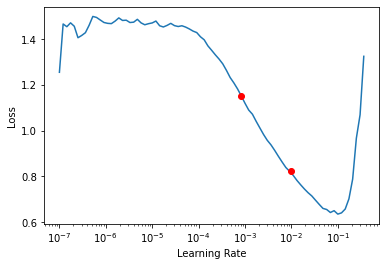

In [9]:
learn.lr_find()

Now we will fine tune the model as a first training step.

In [10]:
learn.fine_tune(1, base_lr = 9e-3)

Now that we have done some training, we will need to re-run the learning rate finder.  As the model changes and trains, we can find a new 'best' learning rate.

When we run it below, we see the graph is a bit tricker.  We definitely don't want the point to the far left where the loss is spiking.  But we also don't want the point on the right where the loss is increasing.  For this we will find a value between the two on that curve where loss is decreasing and train some mode.

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=1.0964781722577754e-06)

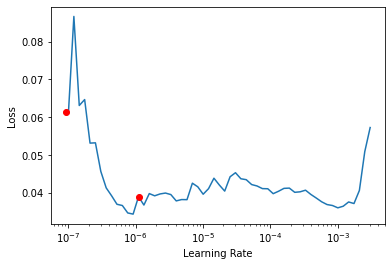

In [11]:
learn.lr_find()

We end up with a 0.6% error rate.  Not bad!

In [14]:
learn.fit_one_cycle(1,9e-7)